# Compression via the PCA and the SVD

> This part of Notebook 15, Part 0, does not have any exercises. However, you should read through the code and explanation and try to understand it.

The main topic of this lesson is a data analysis method referred to as _Principal Components Analysis_ (PCA). The method requires computing the eigenvectors of a certain matrix; one way to compute those eigenvectors is to use a special factorization from linear algebra called the _Singular Value Decomposition_ (SVD).

This notebook is simply a collection of notes with a little bit of code to help illustrate the main ideas. It does not have any exercises that you need to submit. However, you should try to understand all the code steps that appear in the subsection entitled, **Principal Components Analysis (PCA)**, as you will need to apply the SVD in a subsequent part of this assignment.

**Motivation: data "compression."** In previous lessons, we've looked at a few of the major tasks in data analysis: _ranking_, _regression_, _classification_, and _clustering_. Beyond these, the last problem you'll consider in our class is what we'll call _compression_.

At a high level, the term compression simply refers to finding any compact representation of the data. Such representations can help us in two ways. First, it can make the data set smaller and therefore faster to process or analyze. Secondly, choosing a clever representation can reveal hidden structure.

As a concrete example, consider the problem of _dimensionality reduction_: given a $d$-dimensional data set, we wish to transform it into a smaller $k$-dimensional data set where $k \leq d$.

Choosing the $k$ dimensions in a clever way might even reveal structure that is hard to see in all $d$ original dimensions. For instance, look at the examples at the "visualizing PCA" website:

http://setosa.io/ev/principal-component-analysis/

## Data: Nutrition in the UK

Here is one of those examples, which is nutritional data gathered in a study of four countries of the United Kingdom. (Researchers tabulated the average number of grams consumed per week by an individual living in a particular country, broken down along various food and drink categories.)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))

URL_BASE = "https://cse6040.gatech.edu/datasets/uk-food/"
DATA_PATH = "./resource/asnlib/publicdata/" if on_vocareum() else ""
datasets = {'uk-nutrition-data.csv': 'a6cdc2fb658bacfdf50797c625aa3815'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

'uk-nutrition-data.csv' is ready!

(All data appears to be ready.)


17 x 5 table of data:


,Product,England,Northern Ireland,Scotland,Wales
0,Alcoholic drinks,375,135,458,475
1,Beverages,57,47,53,73
2,Meat,245,267,242,227
3,Cereals,1472,1494,1462,1582
4,Cheese,105,66,103,103


...


Text(0.5, 0.98, 'Grams per week per person')

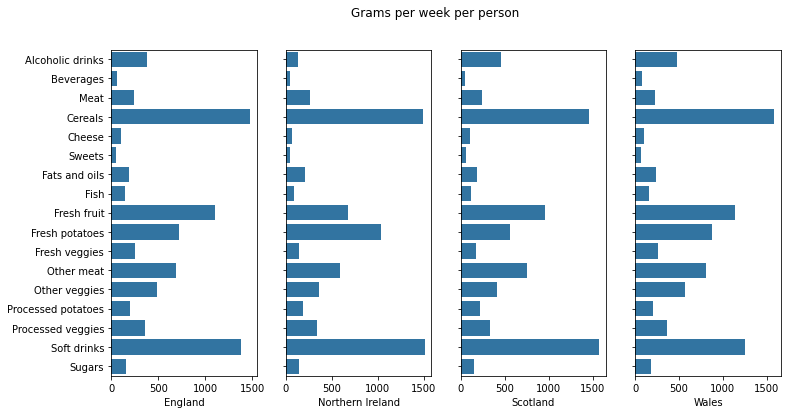

In [3]:
df_uk = pd.read_csv('{}uk-nutrition-data.csv'.format(DATA_PATH))
print("{} x {} table of data:".format(df_uk.shape[0], df_uk.shape[1]))
display(df_uk.head ())
print("...")

fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)
countries = df_uk.columns.difference(['Product'])
for i in range(len(countries)):
    sns.barplot(x=countries[i], y='Product', data=df_uk, ax=axes[i])
    axes[i].set_ylabel("")
fig.suptitle("Grams per week per person")

Do the countries differ in any significant way? Looking only at the bar charts, it is probably hard to tell unless you are very perceptive, and in any case, visual inspection is a very _ad hoc_ technique. Is there a more systematic way?

# Principal components analysis (PCA)

The method of _principal components analysis_ (PCA) is one such technique. For this example, it would start by viewing these data as four (4) data points, one for each country, embedded in a 17-dimensional space (one dimension per food category). The following page will help build your intuition for PCA; the notes that then follow below show formally how PCA works and derives an algorithm to compute it.

http://setosa.io/ev/principal-component-analysis/

## Basic definitions

**Input data matrix, centered.** Per our usual conventions, let $\hat{x}_0, \ldots, \hat{x}_{m-1}$ be th $m$ data points, where each $x_i \in \mathbb{R}^d$ is a single observation. Each observation is represented by a $d$-dimensional real-valued vector corresponding to $d$ measured predictors. As usual, we can stack these into a data matrix, denoted $X \equiv \left(\begin{array}{c} \hat{x}_0^T \\ \vdots \\ \hat{x}_{m-1}^T \end{array}\right)$.

However, we'll add one more important assumption: these data should be _centered_ about their mean, i.e., $\frac{1}{m} \sum_{i=0}^{m-1} \hat{x}_i = 0$. If the observations are not centered initially, then preprocess them accordingly.

**Projections.** Let $\varphi \in \mathbb{R}^d$ be a vector of unit length, i.e., $\|\varphi\|_2^2 = \varphi^T \varphi = 1$. The _projection_ of a data point $\hat{x}_i$ onto $\varphi$ is $\hat{x}_i^T \varphi$, which measures the length of the projected vector.

The following code cell illustrates a projection. Given a vector `x_hat` and a line represented by a unit vector `phi`, it computes the projection  `x_hat_proj_phi` of `x_hat` onto `phi`.

In [4]:
# Define a projection
x_hat = np.array([0.25, 0.75]) # Vector to project
phi = np.array([0.5, 0.25]) ; phi = phi / np.linalg.norm(phi) # Unit vector onto which to project x_hat
x_hat_proj_phi = x_hat.T.dot(phi) * phi # Carry out the projection
print(x_hat, phi, x_hat_proj_phi)

[0.25 0.75] [0.89442719 0.4472136 ] [0.5  0.25]


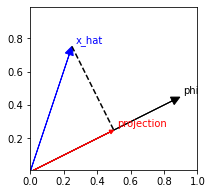

* Black arrow: `phi` (len=1.000)
* Blue arrow: `x_hat` (len=0.791)
* Red arrow: projection of `x_hat` onto `phi` (len=0.559)


In [5]:
# Visualize the projection (you don't need to understand this code cell in any detail)
import matplotlib.lines as mlines

plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.arrow(0, 0, x_hat[0], x_hat[1], head_width=0.05, head_length=0.05, fc='b', ec='b', length_includes_head=True)
ax.arrow(0, 0, phi[0], phi[1], head_width=0.05, head_length=0.05, fc='k', ec='k', length_includes_head=True)
ax.arrow(0, 0, x_hat_proj_phi[0], x_hat_proj_phi[1], head_width=0.025, head_length=0.025, fc='r', ec='r', length_includes_head=True)

perp_line = mlines.Line2D([x_hat[0], x_hat_proj_phi[0]],
                          [x_hat[1], x_hat_proj_phi[1]],
                          linestyle='--', color='k')
ax.add_line(perp_line)
ax.axis('equal') # Equal ratios, so you can tell what is perpendicular to what
ax.axis([0, 1, 0, 1])

dx, dy = 0.02, 0.02
plt.annotate('x_hat', xy=(x_hat[0]+dx, x_hat[1]+dy), color='b')
plt.annotate('phi', xy=(phi[0]+dx, phi[1]+dy), color='k')
plt.annotate('projection', xy=(x_hat_proj_phi[0]+dx, x_hat_proj_phi[1]+dy), color='r')

plt.show()

msg = """* Black arrow: `phi` (len={:.3f})
* Blue arrow: `x_hat` (len={:.3f})
* Red arrow: projection of `x_hat` onto `phi` (len={:.3f})"""
print(msg.format(np.linalg.norm(phi),
                 np.linalg.norm(x_hat),
                 np.linalg.norm(x_hat_proj_phi)))

## Maximizing projections

If the length of a projected data point is large, then intuitively, we have "preserved" its shape. So let's think of the total length of projections of all the data points as a measure of cost, which we can then try to maximize.

**Projection cost.** Let $J(\varphi)$ be a cost function that is proportional to the mean squared projections of the data onto $\varphi$:

$$
\begin{array}{rcl}
  J(\varphi)
    & \equiv & \displaystyle
      \frac{1}{2m} \sum_{i=0}^{m-1} (\hat{x}_i^T \varphi)^2.
\end{array}
$$

The additional factor of "1/2" is for aesthetic reasons. (It cancels out later on.)

Let's also apply some algebra-fu to the right-hand side to put it into a more concise matrix form:

$$
\begin{array}{rcl}
  J(\varphi)
    &    =   & \displaystyle
      \frac{1}{2} \varphi^T \left(\frac{1}{m} \sum_{i=0}^{m-1} \hat{x}_i \hat{x}_i^T \right) \varphi \\
    &    =   & \displaystyle
      \frac{1}{2} \varphi^T \left(\frac{1}{m} X^T X\right) \varphi \\
    & \equiv & \displaystyle
      \frac{1}{2} \varphi^T C \varphi.
\end{array}
$$

In the last step, we defined $C \equiv \frac{1}{m} X^T X$. In statistics, if $X$ represents mean-centered data, then the matrix $C$ is also known as the [_sample covariance matrix_](https://en.wikipedia.org/wiki/Sample_mean_and_covariance) of the data.

**Principal components via maximizing projections.** There are several ways to formulate the PCA problem. Here we consider the one based on _maximizing projections_.

Start by defining a _principal component_ of the data $X$ to be a vector, $\varphi$, of unit length that maximizes the sum of squared projections.

To convert this definition into a formal problem, there is a technique known as the _method of Langrange multipliers_, which may be applied to any minimization or maximization problem that has equality constraints. The idea is to convert the constrained problem into an unconstrained problem that will hopefully be easier to solve. (In the previous lessons on linear and logistic regression, recall that you were optimizing _unconstrained_ problems.)

In the method of Lagrange multipliers, the conversion involves taking each constraint and incorporating into the cost function by adding a new term proportional to the constraint. To see how that works, here is an example. In the case of a principal component, the modified cost function is

$$
\begin{array}{rcl}
  \hat{J}(\varphi, \lambda)
    & \equiv & \displaystyle
      J(\varphi) + \frac{\lambda}{2} (1 - \varphi^T \varphi),
\end{array}
$$

where the second term captures the constraint: it introduces a dummy optimization parameter, $\lambda$, times the constraint that $\varphi$ has unit length, i.e., $\|\varphi\|_2^2 = \varphi^T \varphi = 1$, or $1 - \varphi^T \varphi = 0$. In just a moment, you will see why you are incorporating the constraint in this way. But for now, observe that when the constraint is satisfied, meaning $\|\varphi\|_2^2 = 1$, this new objective function is the same as the original (unconstrained) objective.

> As before, the factor of "1/2" is there solely for aesthetic reasons and will "cancel out," as you'll soon see.

For this new cost function, the optimization task is to find the $\varphi_*$ and $\lambda_*$ that maximize $\hat{J}$:

$$
\begin{array}{rcl}
  (\varphi_*, \lambda_*)
    & \equiv & \displaystyle
      \underset{\varphi, \lambda}{\arg\max} \, \hat{J}(\varphi, \lambda).
\end{array}
$$

To solve this optimization problem, you just need to "take derivatives" of $\hat{J}$ with respect to $\varphi$ and $\lambda$, and then set these derivatives to 0.

> To prove any such extreme points maximize $\hat{J}$, you need to use the fact that it is a _convex function_ [link](https://en.wikipedia.org/wiki/Convex_function).) For problems that are nonconvex and have a cost function that is harder to differentiate, gradient descent (which you have already seen) is a useful method to find at least a local minimum or maximum value.

**Exercise (optional).** Show that

$$
\begin{array}{rcl}
  \nabla_\varphi \hat{J} & = & C \varphi - \lambda \varphi \\
  \displaystyle \frac{\partial}{\partial \lambda} \hat{J} & = & \frac{1}{2} (1 - \varphi^T \varphi).
\end{array}
$$

Setting these to zero and solving yields the following computational problem:

$$
\begin{array}{rcl}
  C \varphi = \frac{1}{m} X^T X \varphi & = & \lambda \varphi \\
  \| \varphi \|_2^2 & = & 1.
\end{array}
$$

> Is it now clear why the constraint was incorporated into $\hat{J}$ as it was? Doing so produces a second equation that _exactly_ captures the constraint!

This problem is an _eigenproblem_, which is the task of computing an eigenvalue and its corresponding eigenvector of $C = \frac{1}{m} X^T X$.

The matrix $C$ will usually have many eigenvalues and eigenvectors. So which one do you want? Plug the eigenvector back into the original cost function. Then, $J(\varphi) = \frac{1}{2} \varphi^T C \varphi = \frac{\lambda}{2} \varphi^T \varphi = \frac{\lambda}{2}$. In other words, to maximize $J(\varphi)$ you should pick the $\varphi$ with the largest eigenvalue $\lambda$.

### Finding an eigenpair via the SVD

So how do you find the eigenvectors of $C$? That is, what algorithm will compute them?

One way is to form $C$ explicitly and then call an off-the-shelf eigensolver. However, forming $C$ explicitly from the data $X$ may be costly in time and storage, not to mention possibly less accurate. (Recall the condition number blow-up problem in the case of solving the normal equations.)

Instead, we can turn to the "Swiss Army knife" of linear algebra, which is the _singular value decomposition_, or SVD. It is an extremely versatile tool for simplifying linear algebra problems. It can also be somewhat expensive to compute accurately, but a lot of scientific and engineering effort has gone into building robust and reasonably efficient SVD algorithms. So let's assume these exist -- and they do in both [Numpy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) and [Scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) -- and use them.

**The SVD.** Every real-valued matrix $X \in \mathbb{R}^{m \times d}$ has a _singular value decomposition_. Let $s = \min(m, d)$, i.e., the smaller of the number of rows or columns. Then the SVD of $X$ is the factorization, $X = U \Sigma V^T$, where $U$, $\Sigma$, and $V^T$ are defined as follows.

The matrices $U \in \mathbb{R}^{m \times s}$ and $V \in \mathbb{R}^{d \times s}$ are matrices with orthonormal columns, meaning $U^T U = I$ and $V^T V = I$; and the matrix $\Sigma$ is an $s \times s$ diagonal matrix.

> Note that $V$ is taken to be $d \times s$, so that the $V^T$ that appears in $U \Sigma V^T$ is $s \times d$.)

The columns of $U$ are also known as the _left singular vectors_, and the columns of $V$ are the _right singular vectors_ of $X$. Using our usual "column-view" of a matrix, these vectors are denoted by $u_i$ and $v_i$:

$$
\begin{array}{rcl}
  U & = & \begin{bmatrix} u_0 & u_1 & \cdots & u_{s-1} \end{bmatrix} \\
  V & = & \begin{bmatrix} v_0 & v_1 & \cdots & v_{s-1} \end{bmatrix}
\end{array}
$$

Regarding the diagonal matrix $\Sigma$, its entries are, collectively, called the _singular values_ of $X$. We will assume that the singular values are sorted: $\sigma_0 >= \sigma_1 >= \sigma_2 >= .... >= \sigma_{s-1}$

$$
\begin{bmatrix}
  \sigma_0 &          &        & \\
           & \sigma_1 &        & \\
           &          & \ddots & \\
           &          &        & \sigma_{s-1}
\end{bmatrix}.
$$

From these definitions, the SVD implies that $X V = U \Sigma$. This form is just a compact way of writing down a _system_ of independent vector equations,

$$
\begin{array}{rcl}
  X v_i & = & \sigma_i u_i.
\end{array}
$$

Recall that in PCA, you want to evaluate $C = \frac{1}{m} X^T X$. In terms of the SVD,

$$X^T X = V \Sigma^T U^T U \Sigma V^T = V \Sigma^2 V^T,$$

using the fact that $ (AB)^{T} = B^{T}A^{T}$ and $U^{T}U = I$ since U is orthogonal. Thus,

$$X^T X V = V \Sigma^2.$$

This relation may in turn be rewritten as the system of vector equations,

$$
\begin{array}{rcl}
  X^T X v_i & = & \sigma_i^2 v_i.
\end{array}
$$

In other words, every pair $(\varphi, \lambda) \equiv \left(v_i, \frac{\sigma_i^2}{m}\right)$ is a potential solution to the eigenproblem, $C\varphi = \frac{1}{m} X^T X \varphi = \lambda \varphi$. The pair with the largest eigenvalue is $\left(v_0, \frac{\sigma_0^2}{m}\right)$.

### Rank-$k$ approximations: the truncated SVD

We motivated PCA by asking for a single vector $\varphi$, which effectively projects the data onto a one-dimensional subspace (i.e., a line). You might instead want to represent the original $d$-dimensional data points on a $k$-dimensional surface or subspace, where $k \leq s \leq d$. As the previous discussion suggests, you could choose the top-$k$ right singular vectors of $X$, $v_0, \ldots, v_{k-1}$.

Indeed, there is another "principled" reason for this choice.

Let $A \in \mathbb{R}^{m \times d}$ be any matrix with an SVD given by $A = U \Sigma V^T$. Per the notation above, let $s \equiv \min(m, d)$.

Then, define the _$k$-truncated SVD_ as follows. Consider any $k \leq s$, and let $U_k$, $\Sigma_k$, and $V_k$ consist of the singular vectors and values corresponding to the $k$ largest singular values. That is, $U_k$ is the first $k$ columns of $U$, $V_k$ is the first $k$ columns of $V$, and $\Sigma_k$ is the upper $k \times k$ submatrix of $\Sigma$. The $k$-truncated SVD is the product $U_k \Sigma_k V_k^T$.

Now consider the following alternative way to write the SVD:

$$
  A = U \Sigma V^T = \sum_{i=0}^{s-1} u_i \sigma_i v_i^T.
$$

Each term, $u_i \sigma_i v_i^T$ is known as a _rank-$1$_ product. So the existence of the SVD means that $A$ may be written as a sum of rank-1 products.

It would be natural to try to _approximate_ $A$ by truncating the SVD after $k$ terms, i.e.,

$$
  A \approx U_k \Sigma_k V_k^T = \sum_{i=0}^{k-1} u_i \sigma_i v_i^T.
$$

And in fact, there is _no_ rank-$k$ approximation of $A$ that is better than this one!

In particular, consider _any_ pair of $k$ column vectors, $Y_k \in \mathbb{R}^{m \times k}$ and $Z_k \in \mathbb{R}^{d \times k}$; their product, $Y_k Z_k$ has rank at most $k$. Then there is a theorem that says the smallest difference between $A$ and the rank-$k$ product $Y_k Z_k$, measured in the Frobenius norm, is

$$
  \min_{Y_k, Z_k} \|A - Y_k Z_k^T\|_F^2
    = \|A - U_k \Sigma_k V_k^T\|_F^2
    = \sigma_{k}^2 + \sigma_{k+1}^2 + \sigma_{k+2}^2 + \cdots + \sigma_{s-1}^2.
$$

In other words, the truncated SVD gives the best rank-$k$ approximation to $A$ in the Frobenius norm. Moreover, the error of the approximation is the sum of the squares of all the smallest $s-k$ singular values.

Applied to the covariance matrix, $\frac{1}{m} X^T X \approx \frac{1}{m} V_k \Sigma_k^2 V_k^T$ is the best rank-$k$ approximation of $C$ in this sense, which justifies choosing the $k$ eigenvectors corresponding to the top $k$ eigenvalues of $C$ as the principal components.

### Summary: The PCA algorithm

Based on the preceding discussion, here is the basic algorithm to compute the PCA, given the data $X$ and the desired dimension $k$ of the subspace.

1. If the data are not already centered, transform them so that they have a mean of 0 in all coordinates, i.e., $\displaystyle \frac{1}{m} \sum_{i=0}^{m-1} \hat{x}_i = 0$.
2. Compute the $k$-truncated SVD, $\displaystyle X \approx U_k \Sigma_k V_k^T$.
3. Choose $v_0, v_1, \ldots, v_{k-1}$ to be the principal components.

## Demo: PCA on the UK Nutrition Study data

Let's try this algorithm out on the UK Nutrition Study data from above.

In [6]:
countries = ['England', 'Northern Ireland', 'Scotland', 'Wales']
products = df_uk['Product']
X_raw = df_uk[countries].values.T
print("X_raw:", X_raw.shape)

s = min(X_raw.shape)
print("s = min({}, {}) == {}".format(X_raw.shape[0], X_raw.shape[1], s))

X_raw: (4, 17)
s = min(4, 17) == 4


In [7]:
X = X_raw - np.mean(X_raw, axis=0)

In [8]:
type(X_raw[1][1])

numpy.int64

In [9]:
X

array([[ 1.4250e+01, -5.0000e-01, -2.5000e-01, -3.0500e+01,  1.0750e+01,
        -1.2500e+00, -1.2250e+01,  1.6500e+01,  1.3450e+02, -7.8250e+01,
         4.5000e+01, -2.1000e+01,  3.0250e+01, -4.0000e+00,  1.1000e+01,
        -5.3000e+01,  1.7500e+00],
       [-2.2575e+02, -1.0500e+01,  2.1750e+01, -8.5000e+00, -2.8250e+01,
        -1.4250e+01,  3.7500e+00, -3.7500e+01, -2.9350e+02,  2.3475e+02,
        -6.5000e+01, -1.2000e+02, -1.0275e+02, -1.5000e+01, -1.5000e+01,
         7.9000e+01, -1.5250e+01],
       [ 9.7250e+01, -4.5000e+00, -3.2500e+00, -4.0500e+01,  8.7500e+00,
         6.7500e+00, -2.1250e+01, -8.5000e+00, -1.0500e+01, -2.3225e+02,
        -3.7000e+01,  4.4000e+01, -3.9750e+01,  1.8000e+01, -1.2000e+01,
         1.4500e+02, -7.2500e+00],
       [ 1.1425e+02,  1.5500e+01, -1.8250e+01,  7.9500e+01,  8.7500e+00,
         8.7500e+00,  2.9750e+01,  2.9500e+01,  1.6950e+02,  7.5750e+01,
         5.7000e+01,  9.7000e+01,  1.1225e+02,  1.0000e+00,  1.6000e+01,
        -1.7100e+02

In [10]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False) # What does the `full_matrices` flag do?
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("VT:", VT.shape)
# Note the shape of Sigma. Numpy stores a diagonal matrix as a vector for efficiency.

U: (4, 4)
Sigma: (4,)
VT: (4, 17)


Let's inspect the coordinates of the top two (`k_approx`, below) right-singular vectors. The code cell below prints the raw coordinates and also shows them in a plot.

* k = 0:
[-0.46396817 -0.02618776  0.04792763 -0.04770286 -0.05695538 -0.0296502
 -0.00519362 -0.08441498 -0.6326409   0.40140206 -0.15184994 -0.25891666
 -0.24359373 -0.02688623 -0.03648827  0.23224414 -0.03762098]

* k = 1:
[-0.11353652  0.03056054 -0.01391582  0.21259968 -0.01601285 -0.00594992
  0.09538866  0.05075495  0.17774074  0.71501708  0.14490027  0.01533114
  0.22545092 -0.04285076  0.0454518  -0.55512431  0.0430217 ]



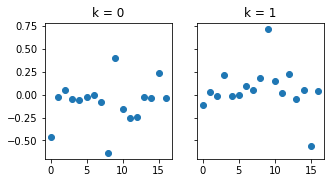

In [11]:
m, d = X.shape
k_approx = 2
assert k_approx <= s

# Plot the components of the first k_approx=2 singular vectors
fig, axs = plt.subplots(1, k_approx, sharex=True, sharey=True,
                        figsize=(2.5*k_approx, 2.5))
for k in range(k_approx):
    v_k = VT[k, :].T
    print(f'* k = {k}:\n{v_k}\n')
    axs[k].scatter(np.arange(max(m, d)), v_k)
    axs[k].set_title(f'k = {k}')

In [12]:
print("Entries of the 1st singular vector with the largest magnitude:")
print(products[[0, 8, 9]])

print("\nEntries of the 2nd singular vector with the largest magnitude:")
print(products[[9, 15]])

Entries of the 1st singular vector with the largest magnitude:
0    Alcoholic drinks
8         Fresh fruit
9      Fresh potatoes
Name: Product, dtype: object

Entries of the 2nd singular vector with the largest magnitude:
9     Fresh potatoes
15       Soft drinks
Name: Product, dtype: object


That is, the entries of the right-singular vectors with the largest magnitudes suggest which food categories carry the most "information," in the sense of preserving the projections of the original vectors.

We can also take the original 17-dimensional data and project them onto the 2-dimensional subspace defined by the first two right-singular vectors. After doing so, does it become more clear which country is not like the others?

* England: (-144.99315218207673, 2.5329994370406372)
* Northern Ireland: (477.3916388161169, 58.90186181595274)
* Scotland: (-91.86933899886358, -286.0817861342623)
* Wales: (-240.5291476351766, 224.64692488126892)


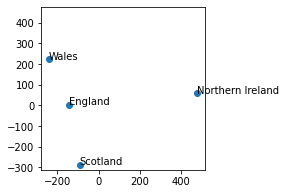

In [13]:
# Project into 2-D
Y_k = X.dot(VT[0:2, :].T)

# Print
for x, y, label in zip(Y_k[:, 0], Y_k[:, 1], countries):
    print(f'* {label}: ({x}, {y})')

# Plot
fig = plt.figure(figsize=(3, 3))
plt.scatter(Y_k[:, 0], Y_k[:, 1])
for x, y, label in zip(Y_k[:, 0], Y_k[:, 1], countries):
    plt.annotate(label, xy=(x, y))
ax = plt.gca()
ax.axis('square');

**Fin!** That's the end of these notes. If you've understood them, you are ready to move on to the next notebook in this assignment.